# 線形判別分析(LDA)を用いてwineデータを分類する

使用したデータセットはwineデータセットであり、3種類のワインと13種類の説明変数からなる\
ここではクラスの分離を2次元平面上に行うことで次元削減を行うことを考える

In [45]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
# wineデータセットの読み込み
df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/'
                      'machine-learning-databases/wine/wine.data', header=None)

df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash', 'Alcalinity of ash', 'Magnesium', 'Total phenols',
                   'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins', 'Color intensity', 'Hue', 'OD280/OD315 of diluted wines', 'Proline']
print(df_wine.head())

   Class label  Alcohol  Malic acid   Ash  Alcalinity of ash  Magnesium  \
0            1    14.23        1.71  2.43               15.6        127   
1            1    13.20        1.78  2.14               11.2        100   
2            1    13.16        2.36  2.67               18.6        101   
3            1    14.37        1.95  2.50               16.8        113   
4            1    13.24        2.59  2.87               21.0        118   

   Total phenols  Flavanoids  Nonflavanoid phenols  Proanthocyanins  \
0           2.80        3.06                  0.28             2.29   
1           2.65        2.76                  0.26             1.28   
2           2.80        3.24                  0.30             2.81   
3           3.85        3.49                  0.24             2.18   
4           2.80        2.69                  0.39             1.82   

   Color intensity   Hue  OD280/OD315 of diluted wines  Proline  
0             5.64  1.04                          3.92  

In [3]:
# 訓練データとテストデータに分ける
# ここではsckit-learnのライブラリで7:3に分けている
x, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, stratify=y, random_state=0)  
print(x_train.shape)
print(y_train.shape)

(124, 13)
(124,)


### データを標準化する
$$
z_i=\frac{x_i-\mu}{\sigma}
$$
ここで$\mu$は平均、$\sigma$は分散を表す

In [47]:
import math
# データの標準化を行う関数
def standardize(x):
    return (x-x.mean()) / x.std()

In [48]:
# xデータの標準化
x_train_std = standardize(x_train)
x_test_std = standardize(x_test)

#ライブラリを用いた場合
#sc = StandardScaler()
#x_train_std = sc.fit_transform(x_train)
#x_test_std = sc.transform(x_test)

# 平均ベクトルの計算
np.set_printoptions(precision=4)
mean_vecs = []
for label in range(1, 4):
    mean_vecs.append(np.mean(x_train_std[y_train == label], axis=0))
    print(mean_vecs[label - 1])

[-0.2556 -0.3096 -0.3072 -0.239   0.1665 -0.3054 -0.3046 -0.3172 -0.3096
 -0.2928 -0.3136 -0.3045  4.924 ]
[-0.2623 -0.3093 -0.3081 -0.2233  0.1094 -0.308  -0.3088 -0.3169 -0.3108
 -0.3042 -0.3139 -0.3054  2.0513]
[-0.2582 -0.3032 -0.3074 -0.2218  0.1312 -0.3108 -0.3151 -0.3164 -0.3131
 -0.2849 -0.3154 -0.3109  2.5328]


In [49]:
# クラス内共分散行列の計算
d = 13 
S_w = np.zeros((d, d))
for label, mv in zip(range(1, 4), mean_vecs):
    class_scatter = np.zeros((d, d))  
    for row in x_train_std[y_train == label]:
        row, mv = row.reshape(d, 1), mv.reshape(d, 1)  
        class_scatter += (row - mv).dot((row - mv).T)
    S_w += class_scatter                          
print((S_w.shape[0], S_w.shape[1]))
print(np.bincount(y_train)[1:])

(13, 13)
[41 50 33]


In [50]:
# numpyを用いてクラス内共分散行列を計算する
d = 13  
S_w = np.zeros((d, d))
for label, mv in zip(range(1, 4), mean_vecs):
    class_scatter = np.cov(x_train_std[y_train == label].T)
    S_w += class_scatter
print((S_w.shape[0], S_w.shape[1]))

(13, 13)


上のS_wはどちらを用いても良い

In [51]:
# クラス間共分散行列の計算
mean_overall = np.mean(x_train_std, axis=0)
d = 13  
S_b = np.zeros((d, d))
for i, mean_vec in enumerate(mean_vecs):
    n = x_train[y_train == i+1, :].shape[0]
    mean_vec = mean_vec.reshape(d, 1)  
    mean_overall = mean_overall.reshape(d, 1)  
    S_b += n * (mean_vec - mean_overall).dot((mean_vec - mean_overall).T)
print((S_b.shape[0], S_b.shape[1]))

(13, 13)


In [52]:
# 固有値を計算する
eigen_vals, eigen_vecs = np.linalg.eig(np.linalg.inv(S_w).dot(S_b))
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:, i]) for i in range(len(eigen_vals))]
eigen_pairs = sorted(eigen_pairs, key=lambda k: k[0], reverse=True)
for eigen_val in eigen_pairs:
    print(eigen_val[0])

349.6178089059934
172.76152218979652
5.295472340187752e-14
3.9395830014489546e-14
2.842170943040401e-14
1.8105510738964006e-14
1.8105510738964006e-14
1.7073511538608653e-14
1.2890731655730721e-14
8.341127193727803e-15
8.341127193727803e-15
5.4982471704457185e-15
1.9905428774659485e-15


In [58]:
# 固有値の寄与率と累積寄与率
tot = sum(eigen_vals.real)
discr = [(i / tot) for i in sorted(eigen_vals.real, reverse=True)]
cum_discr = np.cumsum(discr)
print('Contribution Ratio:\n', discr)
print()
print('Cumulative Contribution Ratio:\n', cum_discr)

Contribution Ratio:
 [0.6692795600710381, 0.330720439928962, 1.0137216434424181e-16, 5.4408181446965127e-17, 2.4676955783625594e-17, 1.4733898575259882e-17, 1.4733898575259882e-17, 1.1743872833547115e-17, 1.1743872833547115e-17, -3.810531464348726e-18, -1.0525391881244804e-17, -3.2684125351578744e-17, -7.541613473076989e-17]

Cumulative Contribution Ratio:
 [0.6693 1.     1.     1.     1.     1.     1.     1.     1.     1.
 1.     1.     1.    ]


In [42]:
# 射影行列を設定
w = np.hstack((eigen_pairs[0][1][:, np.newaxis].real,
              eigen_pairs[1][1][:, np.newaxis].real))
print(w)

[[-0.1552 -0.2584]
 [ 0.067  -0.0701]
 [-0.054  -0.6861]
 [ 0.0385  0.0504]
 [-0.001  -0.003 ]
 [ 0.2686  0.0712]
 [-0.6213  0.144 ]
 [-0.5344 -0.0436]
 [ 0.0027  0.0799]
 [ 0.1075 -0.0474]
 [-0.1283  0.647 ]
 [-0.4418 -0.0093]
 [-0.001  -0.001 ]]


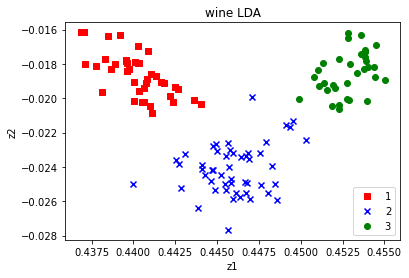

In [61]:
# 訓練データを射影行列wで変換
x_train_lda = x_train_std.dot(w)
colors = ['r', 'b', 'g']
markers = ['s', 'x', 'o']
for l, c, m in zip(np.unique(y_train), colors, markers):
    plt.scatter(x_train_lda[y_train == l, 0],
                x_train_lda[y_train == l, 1] * (-1), c=c, label=l, marker=m)
plt.title('wine LDA')
plt.xlabel('z1')
plt.ylabel('z2')
plt.legend(loc='lower right')
plt.savefig('wine_LDA.png')
plt.show()

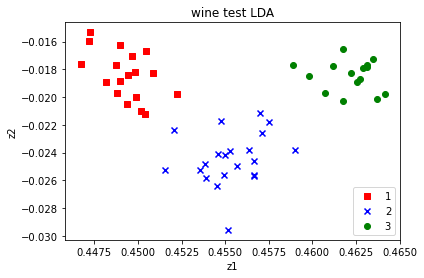

In [62]:
x_test_lda = x_test_std.dot(w)
colors = ['r', 'b', 'g']
markers = ['s', 'x', 'o']
for l, c, m in zip(np.unique(y_test), colors, markers):
    plt.scatter(x_test_lda[y_test == l, 0],
                x_test_lda[y_test == l, 1] * (-1), c=c, label=l, marker=m)
plt.title('wine test LDA')
plt.xlabel('z1')
plt.ylabel('z2')
plt.legend(loc='lower right')
plt.savefig('wine_LDA_test.png')
plt.show()

テストデータでk近傍法などを用いて分類分けした結果と比べると正解率を計算することができる